# Designing a polarization splitter/rotator on thin-film lithium niobate

Note: the cost of running the total notebook is almost 27.5 FlexCredits. The cost of running the FDTD validation is just over 26 FlexCredits.

Here we design a polarization splitter/rotator (PSR) on the lithium niobate on insulator (LNOI) platform based on `Xuanhao Wang, An Pan, Tingan Li, Cheng Zeng, and Jinsong Xia, "Efficient polarization splitter-rotator on thin-film lithium niobate," Opt. Express 29, 38044-38052 (2021)` [DOI: 10.1364/OE.443798](https://doi.org/10.1364/OE.443798) and follow the same design process. This will operate in a bandwidth of 1.5 μm to 1.6 μm.

<center>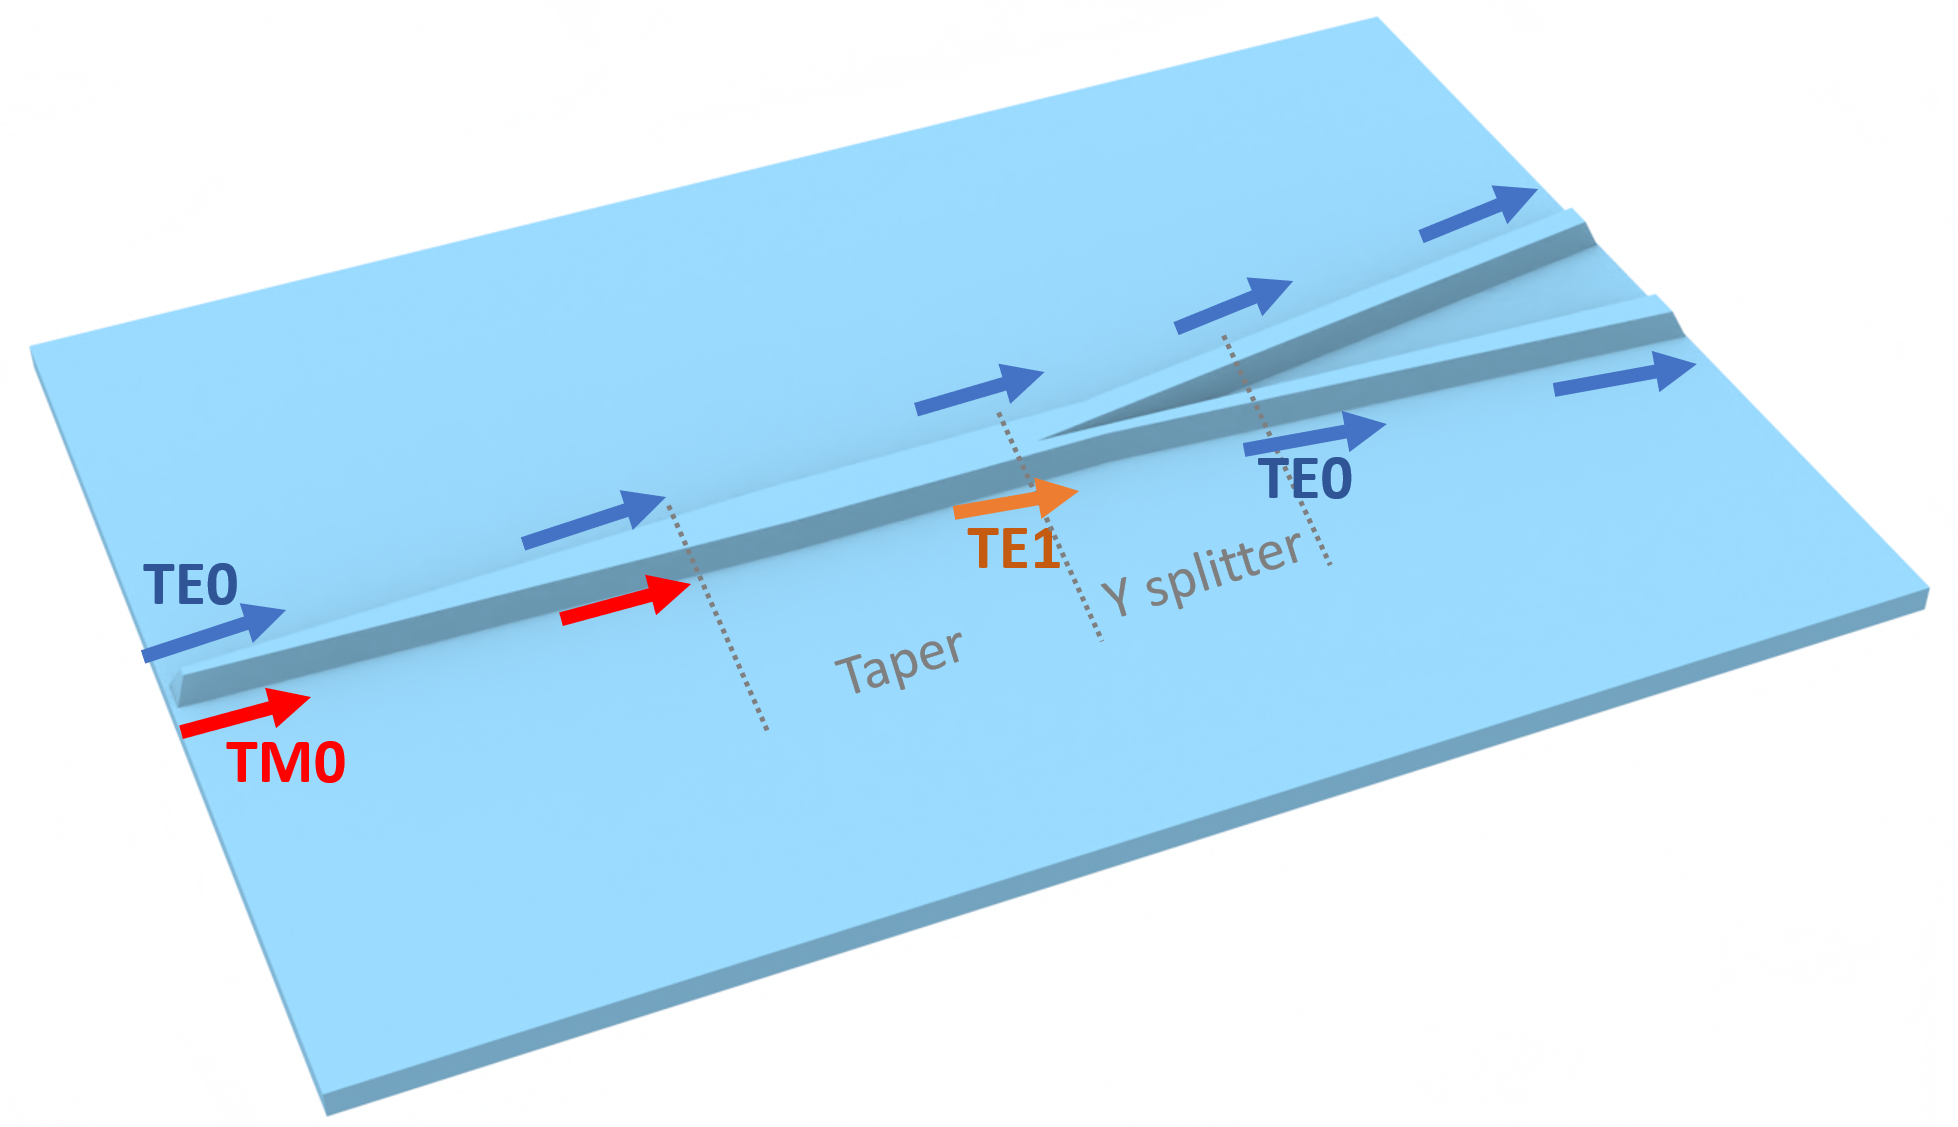</center>

PSRs are useful devices that control optical input. By splitting and rotating its input, a PSR can isolate different modes and transform them according to our needs. This PSR consists of an adiabatic taper to convert the TM0 mode to TE1 mode and an asymmetric Y-junction that separates TE0 and TE1 modes. In this way, our PSR is able to split TE0 and TM0 modes, and rotate the TM0 mode into a TE0 mode. Devices like these allow us to modulate inputs and interface with other optical devices in a controlled way.

In this design process, we will optimize the taper and Y-junction separately using a combination of `Tidy3D`'s mode solver and eigenmode expansion (EME) solver. Finally we validate our optimized designs with FDTD to further ensure the performance.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tidy3d as td
import tidy3d.web as web
from tidy3d import material_library
from tidy3d.plugins.mode import ModeSolver
from tidy3d.plugins.mode.web import run as run_mode_solver

## Simulation Setup

First we define some values in our bandwidth and LNOI setup. Our LNOI setup consists of a lithium niobate (LN) structure with a sidewall angle of 20 degree on top of a thin film that is also LN. All of our LNOI structures will be defined in this way.

In [2]:
wvl0 = 1.55  # central wavelength for device
freq0 = td.C_0 / wvl0  # central frequency
wvls = np.linspace(1.5, 1.6, 41)  # bandwidth we'll consider for device
freqs = td.C_0 / wvls  # corresponding frequency range

sidewall_angle = np.deg2rad(20)
etch_depth = 0.26
film_thickness = 0.5

LN is an anisotropic medium, with different refractive indices in the ordinary and extraordinary directions. We incorporate this information using Tidy3D's [AnisotropicMedium](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.AnisotropicMedium.html) object. Since the propagation direction of the PSR will be defined along the x-direction, this will have the ordinary refractive index.

<i>NOTE: Tidy3D offers lithium niobate in its [material library](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/material_library.html#lithium-niobate-linbo3). However, the values there differ slightly from the values used in the paper on which this notebook is based, so we will use the latter.</i>

In [3]:
n_e = 2.169  # extraordinary refractive index of LN
n_o = 2.234  # ordinary refractive index of LN
n_SiO2 = 1.46  # refractive index of SiO2

# define LN medium
LN_e = td.Medium(permittivity=n_e**2)
LN_o = td.Medium(permittivity=n_o**2)
LN = td.AnisotropicMedium(xx=LN_o, yy=LN_e, zz=LN_o)

# define SiO2 medium
SiO2 = td.Medium(permittivity=n_SiO2**2)

Next we define a function that takes in a set of points (like a polyslab) and produces the corresponding LNOI structure:

In [4]:
def make_ridge_waveguide(pts):
    """
    Define the sidewall angled waveguide that sits on top of a Lithium Niobate film:
    """
    LN_slab_thickness = film_thickness - etch_depth
    waveguide_geo = td.PolySlab(
        sidewall_angle=sidewall_angle,
        vertices=pts,
        reference_plane="bottom",
        slab_bounds=[-0.005, etch_depth],
    )
    waveguide = td.Structure(geometry=waveguide_geo, medium=LN)

    """
    Define the film that the waveguide sits on:
    """
    LN_slab_geo = td.Box(
        center=(0, 0, -LN_slab_thickness / 2),  # ensure overlap
        size=(td.inf, td.inf, LN_slab_thickness),
    )
    LN_slab = td.Structure(geometry=LN_slab_geo, medium=LN)

    return [LN_slab, waveguide]

## Mode Analysis
To design our adiabatic taper, we want to determine the LNOI cross section at which a TM0 mode hybridizes with the TE1 mode. To do this, we will use Tidy3D's mode solver for cross sections at increasing LNOI taper widths. We will do this by creating a single taper structure on LNOI and placing mode solver planes along the taper.

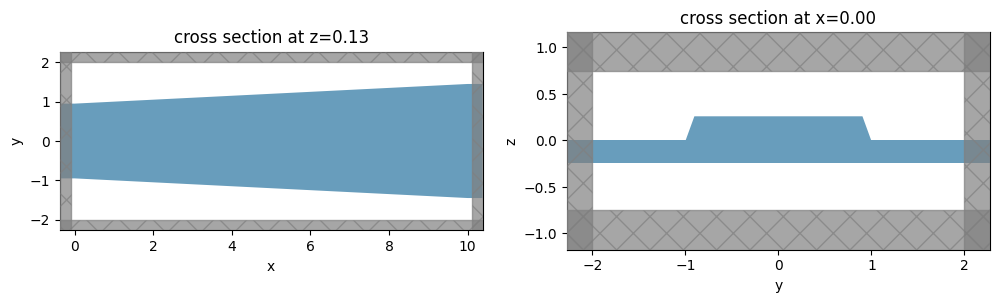

In [5]:
# We will define the taper by a (somewhat arbitrary) difference in widths over a length.

width_test_w0 = 2  # starting width of taper
width_test_w1 = 3  # ending width of taper
width_test_length = 10  # length of taper

"""
Define points that take the shape of a taper. Note that we extend the inital and final
widths past the boundaries to avoid the sidewall angles from interfering with the ends
of the taper.
"""
width_test_pts = [
    (-1, -width_test_w0 / 2),
    (0, -width_test_w0 / 2),
    (width_test_length, -width_test_w1 / 2),
    (width_test_length + 1, -width_test_w1 / 2),
    (width_test_length + 1, width_test_w1 / 2),
    (width_test_length, width_test_w1 / 2),
    (0, width_test_w0 / 2),
    (-1, width_test_w0 / 2),
]
width_test_structures = make_ridge_waveguide(width_test_pts)

# create simulation environment of the taper
width_test_sim = td.Simulation(
    center=(width_test_length / 2, 0, 0),
    size=(width_test_length + 0.2, 2 * width_test_w0, 3 * film_thickness),
    structures=width_test_structures,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=30, wavelength=wvl0),
    medium=SiO2,
    run_time=1e-15,
)

# plot the simulation to check the taper and LNOI geometry
_, ax = plt.subplots(1, 2, figsize=(12, 4))
width_test_sim.plot(z=etch_depth / 2, ax=ax[0])
width_test_sim.plot(x=0, ax=ax[1])
plt.show()

To find the relationship between modes and width, we will place mode solver planes along the taper (along the x direction). These planes will solve for modes at each cross-section, which will be increasing in thickness as we go along the taper. This will tell us at which thickness a mode conversion will occur.<br>

<i>NOTE: Since this cell runs the remote mode solver in series, it may take a couple minutes to run.</i>

In [6]:
plane_xs = np.linspace(0, width_test_length, 31)  # x values of the mode solver planes

# modespec for the mode solver planes
width_test_mode_spec = td.ModeSpec(num_modes=3, target_neff=n_o)

# create and place mode planes, then solve for mode data
modes, te_fracs = np.zeros((3, len(plane_xs))), np.zeros((3, len(plane_xs)))

for i, m in enumerate(plane_xs):

    # define plane at x coordinate
    plane = td.Box(center=(m, 0, 0), size=(0, td.inf, td.inf))

    # create mode solver from plane
    mode_solver = ModeSolver(
        simulation=width_test_sim, plane=plane, mode_spec=width_test_mode_spec, freqs=[freq0]
    )

    # collect data from this mode solver plane
    mode_data = run_mode_solver(mode_solver)  # mode_solver.solve()
    modes[:, i] = mode_data.n_eff.data
    te_fracs[:, i] = mode_data.pol_fraction.te.data[0]

07:56:30 PDT Mode solver created with                                           
             task_id='fdve-ea87d3b9-59b6-4136-8cdb-107df1ddca73',               
             solver_id='mo-6ca7a3a9-1997-4c48-a6dc-8a49c2bf4e27'.

Output()

Output()

07:56:32 PDT Mode solver status: queued

07:56:34 PDT Mode solver status: running

07:56:41 PDT Mode solver status: success

Output()

07:56:43 PDT Mode solver created with                                           
             task_id='fdve-7b9b4ecb-2021-4261-9a77-939d618d1147',               
             solver_id='mo-61e26996-0bf2-4378-bf2f-8b18f4437a04'.

Output()

Output()

07:56:45 PDT Mode solver status: queued

07:56:46 PDT Mode solver status: running

07:56:53 PDT Mode solver status: success

Output()

07:56:55 PDT Mode solver created with                                           
             task_id='fdve-66c75bd5-1610-435f-be82-bd4b2aaa3663',               
             solver_id='mo-300874a4-50f9-4063-85a5-0e3f6135b1d5'.

Output()

Output()

07:56:57 PDT Mode solver status: queued

07:56:59 PDT Mode solver status: running

07:57:05 PDT Mode solver status: success

Output()

07:57:06 PDT Mode solver created with                                           
             task_id='fdve-0d99e7d1-ea7c-45b7-847f-97fbb9edeb38',               
             solver_id='mo-2b7a0260-30e1-4f72-863a-a572d7642e65'.

Output()

Output()

07:57:09 PDT Mode solver status: queued

07:57:11 PDT Mode solver status: running

07:57:16 PDT Mode solver status: success

Output()

07:57:18 PDT Mode solver created with                                           
             task_id='fdve-2e46c47b-c5d0-424e-8fea-03636f806c1e',               
             solver_id='mo-9e24da04-7aa7-4029-ae03-38b9154ef70e'.

Output()

Output()

07:57:20 PDT Mode solver status: queued

07:57:22 PDT Mode solver status: running

07:57:28 PDT Mode solver status: success

Output()

07:57:29 PDT Mode solver created with                                           
             task_id='fdve-6ac91d75-aa74-45d9-b065-9b7d119b11ed',               
             solver_id='mo-ad56cffd-abda-4d9d-afe0-36f1aa1c3b7d'.

Output()

Output()

07:57:32 PDT Mode solver status: queued

07:57:33 PDT Mode solver status: running

07:57:40 PDT Mode solver status: success

Output()

07:57:42 PDT Mode solver created with                                           
             task_id='fdve-f84d2a0e-a35a-4c56-bc50-5e277dc0673f',               
             solver_id='mo-af4427a5-ca13-45ef-9b4b-7de4e4bd5ed8'.

Output()

Output()

07:57:44 PDT Mode solver status: queued

07:57:53 PDT Mode solver status: running

07:58:01 PDT Mode solver status: success

Output()

07:58:02 PDT Mode solver created with                                           
             task_id='fdve-9e32338f-3acd-4136-8b04-a6afc1ab6b91',               
             solver_id='mo-673beaed-9013-442f-8bb7-1255879a56b3'.

Output()

Output()

07:58:05 PDT Mode solver status: queued

07:58:06 PDT Mode solver status: running

07:58:12 PDT Mode solver status: success

Output()

07:58:14 PDT Mode solver created with                                           
             task_id='fdve-231e7a4e-d03f-465a-a4ac-0a801e7b3f36',               
             solver_id='mo-40844bb9-80c2-499e-965c-5916de220f02'.

Output()

Output()

07:58:16 PDT Mode solver status: queued

07:58:24 PDT Mode solver status: running

07:58:31 PDT Mode solver status: success

Output()

07:58:33 PDT Mode solver created with                                           
             task_id='fdve-4c2598f2-78e3-4d54-9e60-b8029aff089c',               
             solver_id='mo-79736323-dc8c-49d4-8043-e72b83389b97'.

Output()

Output()

07:58:35 PDT Mode solver status: queued

07:58:37 PDT Mode solver status: running

07:58:43 PDT Mode solver status: success

Output()

07:58:44 PDT Mode solver created with                                           
             task_id='fdve-82e7cc52-d95a-48b8-b865-4f785c08d3dd',               
             solver_id='mo-c63dcebc-159d-45cc-a8f8-65c965944868'.

Output()

Output()

07:58:47 PDT Mode solver status: queued

07:58:48 PDT Mode solver status: running

07:58:55 PDT Mode solver status: success

Output()

07:58:57 PDT Mode solver created with                                           
             task_id='fdve-926e8a3f-a813-4d11-9749-65fdc1e06e29',               
             solver_id='mo-61f1bf11-1235-4f2b-b223-03bca6e70b77'.

Output()

Output()

07:58:59 PDT Mode solver status: queued

07:59:01 PDT Mode solver status: running

07:59:08 PDT Mode solver status: success

Output()

07:59:09 PDT Mode solver created with                                           
             task_id='fdve-679ea717-3178-4326-b4e2-d4fe47354eee',               
             solver_id='mo-e502941a-3b70-4fb7-80e2-2099fd592677'.

Output()

Output()

07:59:12 PDT Mode solver status: queued

07:59:13 PDT Mode solver status: running

07:59:20 PDT Mode solver status: success

Output()

07:59:22 PDT Mode solver created with                                           
             task_id='fdve-40ba0ed8-2f30-4ecf-9ea1-f02d5fd2e916',               
             solver_id='mo-501071ce-92d9-46ec-8e0e-05d6a715ae1d'.

Output()

Output()

07:59:24 PDT Mode solver status: queued

07:59:26 PDT Mode solver status: running

07:59:32 PDT Mode solver status: success

Output()

07:59:33 PDT Mode solver created with                                           
             task_id='fdve-dcdf5e1c-c638-4f13-9c47-5ad1cb2bc13a',               
             solver_id='mo-cfa94eda-9501-4245-b3d5-ff66f63d1f40'.

Output()

Output()

07:59:36 PDT Mode solver status: queued

07:59:37 PDT Mode solver status: running

07:59:44 PDT Mode solver status: success

Output()

07:59:46 PDT Mode solver created with                                           
             task_id='fdve-fb62e74f-473d-4d4d-a352-fd2341e630ab',               
             solver_id='mo-c3c18136-46e3-44b6-bb09-04cbea2ffb70'.

Output()

Output()

07:59:48 PDT Mode solver status: queued

07:59:50 PDT Mode solver status: running

08:00:05 PDT Mode solver status: success

Output()

08:00:06 PDT Mode solver created with                                           
             task_id='fdve-fb83525c-c3ac-46df-b2a5-6902b174fa56',               
             solver_id='mo-94491216-302b-4045-a6ab-bfe8f1c0de40'.

Output()

Output()

08:00:09 PDT Mode solver status: queued

08:00:18 PDT Mode solver status: running

08:00:25 PDT Mode solver status: success

Output()

08:00:26 PDT Mode solver created with                                           
             task_id='fdve-c5606ccc-1ea9-423d-8306-b2b706af51d2',               
             solver_id='mo-f839f3c7-db19-4c58-8599-565471b6ecfe'.

Output()

Output()

08:00:29 PDT Mode solver status: queued

08:00:30 PDT Mode solver status: running

08:00:37 PDT Mode solver status: success

Output()

08:00:39 PDT Mode solver created with                                           
             task_id='fdve-72fcf1ff-41d8-45e1-93b2-81c017c76d54',               
             solver_id='mo-4ef32b77-b497-4eb1-aa5c-aa04871169de'.

Output()

Output()

08:00:42 PDT Mode solver status: queued

08:00:43 PDT Mode solver status: running

08:00:50 PDT Mode solver status: success

Output()

08:00:52 PDT Mode solver created with                                           
             task_id='fdve-98535d05-9c03-44dd-ae65-092211bef8df',               
             solver_id='mo-7226a4a0-ec2c-4bdc-bd83-56ffbac129e2'.

Output()

Output()

08:00:55 PDT Mode solver status: queued

08:00:56 PDT Mode solver status: running

08:01:03 PDT Mode solver status: success

Output()

08:01:04 PDT Mode solver created with                                           
             task_id='fdve-0b149ba0-8a42-4270-986d-dc72aeda146f',               
             solver_id='mo-a3c49bcc-9615-4246-becf-fe0b79156406'.

Output()

Output()

08:01:07 PDT Mode solver status: queued

08:01:09 PDT Mode solver status: running

08:01:16 PDT Mode solver status: success

Output()

08:01:17 PDT Mode solver created with                                           
             task_id='fdve-05f3b612-6130-4768-aa30-89489ec3f802',               
             solver_id='mo-ff4e35e4-1988-492e-a927-023dc49fd3a3'.

Output()

Output()

08:01:20 PDT Mode solver status: queued

08:01:21 PDT Mode solver status: running

08:01:27 PDT Mode solver status: success

Output()

08:01:29 PDT Mode solver created with                                           
             task_id='fdve-48806aea-3f3a-4f23-b69f-b24abb4aa2f1',               
             solver_id='mo-1e0059bc-ed8c-49d9-bc49-23244f39d3e7'.

Output()

Output()

08:01:32 PDT Mode solver status: queued

08:01:34 PDT Mode solver status: running

08:01:44 PDT Mode solver status: success

Output()

08:01:46 PDT Mode solver created with                                           
             task_id='fdve-0af7ba0d-2cf0-463b-98b0-2c3c02f1f7e7',               
             solver_id='mo-39407070-bdec-455b-8574-066f11c61dac'.

Output()

Output()

08:01:48 PDT Mode solver status: queued

08:01:50 PDT Mode solver status: running

08:01:56 PDT Mode solver status: success

Output()

08:01:58 PDT Mode solver created with                                           
             task_id='fdve-553ad655-d34c-43b0-a2cc-104ef4fee954',               
             solver_id='mo-7cf0986a-d790-49b9-aaed-c56103d49c8e'.

Output()

Output()

08:02:00 PDT Mode solver status: queued

08:02:01 PDT Mode solver status: running

08:02:08 PDT Mode solver status: success

Output()

08:02:10 PDT Mode solver created with                                           
             task_id='fdve-86f29c57-aed1-4155-b03f-ddf037b6c747',               
             solver_id='mo-961b1801-e33b-4ad1-9f6d-39edfc83af96'.

Output()

Output()

08:02:12 PDT Mode solver status: queued

08:02:14 PDT Mode solver status: running

08:02:20 PDT Mode solver status: success

Output()

08:02:21 PDT Mode solver created with                                           
             task_id='fdve-7965daf2-292a-458c-a5c7-8fb9068d0ef1',               
             solver_id='mo-6ecf1cde-0934-4167-a43b-34428f978ffc'.

Output()

Output()

08:02:24 PDT Mode solver status: queued

08:02:25 PDT Mode solver status: running

08:02:32 PDT Mode solver status: success

Output()

08:02:34 PDT Mode solver created with                                           
             task_id='fdve-4305f270-0fc5-484f-ab45-43cb9ebec205',               
             solver_id='mo-69db48c4-73a0-42e8-925b-199cf50c1a1c'.

Output()

Output()

08:02:36 PDT Mode solver status: queued

08:02:38 PDT Mode solver status: running

08:02:44 PDT Mode solver status: success

Output()

08:02:46 PDT Mode solver created with                                           
             task_id='fdve-9f03fbce-a085-448a-8278-d5874f3307ea',               
             solver_id='mo-e5e78bd7-da58-46f8-b1dc-4849fd0b1af1'.

Output()

Output()

08:02:49 PDT Mode solver status: queued

08:02:50 PDT Mode solver status: running

08:02:56 PDT Mode solver status: success

Output()

08:02:58 PDT Mode solver created with                                           
             task_id='fdve-a5de6e11-1c74-47fb-bb61-d135c10f5edd',               
             solver_id='mo-29b05f57-1de4-4894-9d58-9afe9c38e236'.

Output()

Output()

08:03:01 PDT Mode solver status: queued

08:03:02 PDT Mode solver status: running

08:03:09 PDT Mode solver status: success

Output()

08:03:11 PDT Mode solver created with                                           
             task_id='fdve-17530bea-6c6b-4d57-9eb1-b562a027f358',               
             solver_id='mo-05dd423c-7338-4949-abd8-48e28696083f'.

Output()

Output()

08:03:14 PDT Mode solver status: queued

08:03:15 PDT Mode solver status: running

08:03:22 PDT Mode solver status: success

Output()

To show the TM0 to TE1 hybridization, we will plot the effective indices vs taper width, as well as the TE fraction as the color of the curves. We can see that around a taper width of 2.55 μm is when the modes cross.

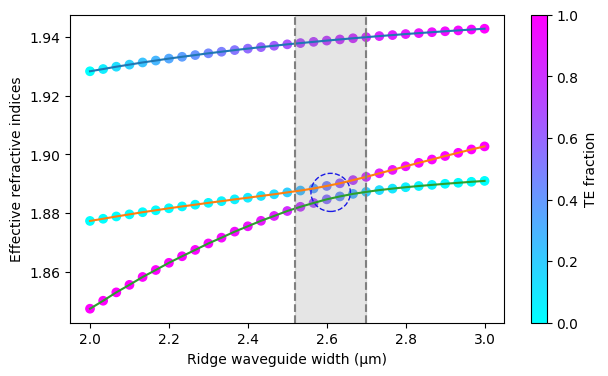

In [7]:
from matplotlib.patches import Ellipse
import matplotlib.colors as mcolors

ridge_waveguide_widths = (
    width_test_w1 - width_test_w0
) / width_test_length * plane_xs + width_test_w0

_, ax = plt.subplots(1, 1, figsize=(7, 4))

conversion = [2.52, 2.7]

ax.plot(ridge_waveguide_widths, modes[0, :], label="TE0")
ax.scatter(ridge_waveguide_widths, modes[0, :], c=te_fracs[0, :], cmap="cool")
ax.plot(ridge_waveguide_widths, modes[1, :], label="TM0")
ax.scatter(ridge_waveguide_widths, modes[1, :], c=te_fracs[1, :], cmap="cool")
ax.plot(ridge_waveguide_widths, modes[2, :], label="TE1")
ax.scatter(ridge_waveguide_widths, modes[2, :], c=te_fracs[2, :], cmap="cool")
circle = Ellipse((2.61, 1.887), width=0.1, height=0.013, ec="blue", fill=False, ls="--")
ax.add_patch(circle)
ax.axvline(x=conversion[0], color="gray", ls="--")
ax.axvline(x=conversion[1], color="gray", ls="--")
ax.axvspan(conversion[0], conversion[1], color="gray", alpha=0.2)
ax.set_xlabel("Ridge waveguide width (μm)")
ax.set_ylabel("Effective refractive indices")

norm = mcolors.Normalize(vmin=0, vmax=1)
plt.colorbar(plt.cm.ScalarMappable(cmap="cool", norm=norm), ax=ax, label="TE fraction")

plt.show()

This mode conversion behavior differs from what is shown in Wang et. al. This is likely due to sub-pixel averaging. When the mode solving is done locally (and thus without subpixel averaging) the result is very similar to what is given in Wang et. al.

## Adiabatic Taper Design

Efficient mode conversion can only happen if the taper changes gradually. Therefore, we will set our conversion taper to be made up of 3 tapers. The first taper will start with a width of 1 μm and end with a width of 2.52 μm. This will be for the single-mode input. The next taper is from 2.52 μm to 2.7 μm for mode conversion. The final taper from 2.7 μm to 3 μm is the connection to the asymmetric Y-junction.

Now that we've established the widths of the tapers, the next question is how long the tapers should be. According to the paper this notebook is based on, the choice of lengths of the first and third tapers do not have a significant effect (as the length of the second taper can be tuned for these choices), and thus will be chosen as 100 μm for each.

In [8]:
l1 = 100  # length of first taper
l3 = 100  # length of third taper

w0 = 1  # starting width of first taper
w1 = conversion[0]  # starting width of second taper
w2 = conversion[1]  # starting width of third taper
w3 = 3  # ending width of third taper

To determine the length of the second taper ($L_2$) that is optimal for mode conversion efficiency, we will run an EME parameter sweep for different simulations with different $L_2$ values. To do this efficiently, we will use the EMELengthSweep feature in Tidy3D's EME simulations, requiring us to only specify the scale factors we'll assign to the EME cells we'd like to vary.

EME is an excellent choice for investigations of this kind. This type of simulation is mainly about solving for modes at different cross sections, and seeing how these modes change from one cross section to another (in this case, along the taper). Since these changes are adiabatic, it is necessary to check for very long lengths in the propagation direction. For this reason, the device can get very large, making FDTD solving very slow and expensive. On the other hand, mode solving in the device's cross section is impacted a lot less by extending the length normal to the cross-section. Since this is mainly what EME relies on, EME will be a much more efficient option.

In [9]:
l2_sweep = 1  # value to construct EME sweep

"""
Hey Tom, I changed these values to get a [straight waveguide]-[l2 taper]-[straight waveguide]
To get the L1 and L3 tapers, change the 'w1's in the first two and last two points to 'w0', and
the 'w2's in the middle four points to 'w3'.
"""

l2_test_pts = [
    (-10, -w0 / 2),  # extend taper into -x boundary
    (0, -w0 / 2),
    (l1, -w1 / 2),
    (l1 + l2_sweep, -w2 / 2),
    (l1 + l2_sweep + l3, -w3 / 2),
    (l1 + l2_sweep + l3 + 10, -w3 / 2),  # extend taper into +x boundary
    (l1 + l2_sweep + l3 + 10, w3 / 2),
    (l1 + l2_sweep + l3, w3 / 2),
    (l1 + l2_sweep, w2 / 2),
    (l1, w1 / 2),
    (0, w0 / 2),
    (-10, w0 / 2),
]
l2_test_structures = make_ridge_waveguide(l2_test_pts)

"""
Here we define the cells we'll use in our EME simulation. We will segment our cells into the three
tapers. Since we care most about our L2 taper, we will divide this into more cells than the other tapers.
"""
num_modes = 4
l1_grid_spec = td.EMEUniformGrid(num_cells=8, mode_spec=td.EMEModeSpec(num_modes=num_modes))
l2_grid_spec = td.EMEUniformGrid(num_cells=15, mode_spec=td.EMEModeSpec(num_modes=num_modes))
l2_total_grid = td.EMECompositeGrid(
    subgrids=[l1_grid_spec, l2_grid_spec, l1_grid_spec], subgrid_boundaries=[l1, l1 + l2_sweep]
)

# define regular mesh grid. This is required for mode solving
auto_x = td.AutoGrid(min_steps_per_wvl=10)
auto_yz = td.AutoGrid(min_steps_per_wvl=30)

l2_scales = np.linspace(1 / l2_sweep, 500 / l2_sweep, 51)
l2_scale_factors = np.ones((len(l2_scales), 2 * l1_grid_spec.num_cells + l2_grid_spec.num_cells))
l2_scale_factors[:, l1_grid_spec.num_cells : l1_grid_spec.num_cells + l2_grid_spec.num_cells] = (
    l2_scales[:, None]
)

# define EME simulation
l2_sweep_sim = td.EMESimulation(
    center=((l1 + l2_sweep + l3) / 2, 0, 0),
    size=(l1 + l2_sweep + l3, w3 + 3 * w0, 5 * film_thickness),
    structures=l2_test_structures,
    grid_spec=td.GridSpec(grid_x=auto_x, grid_y=auto_yz, grid_z=auto_yz, wavelength=wvl0),
    medium=SiO2,
    eme_grid_spec=l2_total_grid,
    freqs=[freq0],
    axis=0,  # EME will be solved along the x axis
    sweep_spec=td.EMELengthSweep(scale_factors=l2_scale_factors),
    symmetry=(0, 1, 0),  # the adiabatic taper has symmetry in y
)

08:03:24 PDT ERROR: Expected 1 dimensions for ArrayLike, got 2.                 

We will plot this simulation just to make sure everything looks correct:

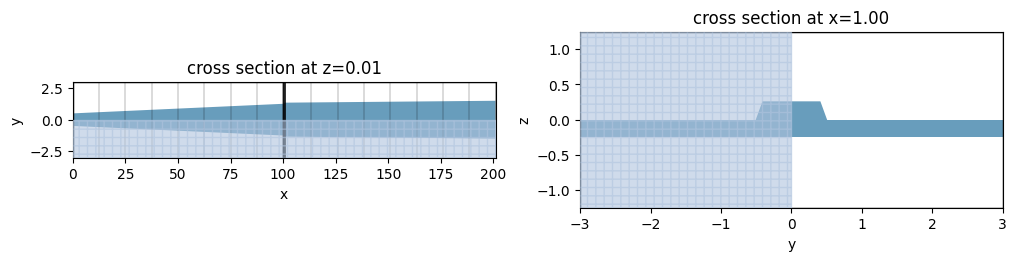

In [10]:
_, ax = plt.subplots(1, 2, figsize=(12, 4))
l2_sweep_sim.plot(z=0.005, ax=ax[0])
l2_sweep_sim.plot(x=l2_sweep, ax=ax[1])
ax[0].set_aspect(6)
plt.show()

Now we will run the EME simulation (sweep):

In [11]:
l2_EME_data = web.run(l2_sweep_sim, task_name="L2 EME sweep")

             Created task 'L2 EME sweep' with task_id                           
             'eme-620af627-814d-4071-bf5f-579247b7a874' and task_type 'EME'.

             Tidy3D's EME solver is currently in the beta stage. Cost of EME    
             simulations is subject to change in the future.

Output()

08:03:26 PDT status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

08:03:29 PDT Maximum FlexCredit cost: 0.231. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

08:06:05 PDT status = success

Output()

08:06:18 PDT loading simulation from simulation_data.hdf5

             ERROR: Expected 1 dimensions for ArrayLike, got 2.                 

Plotting the mode conversion efficiency vs $L_2$, we can determine the optimal $L_2$ value:

In [12]:
l2_TM0_TE1 = l2_EME_data.smatrix.S21.sel(f=freq0, mode_index_in=0, mode_index_out=0).abs.data ** 2

l2_TM0_TM0 = l2_EME_data.smatrix.S21.sel(f=freq0, mode_index_in=0, mode_index_out=1).abs.data ** 2

arg_min = np.argmin(l2_TM0_TM0[:25])
l2 = l2_scales[arg_min] * l2_sweep

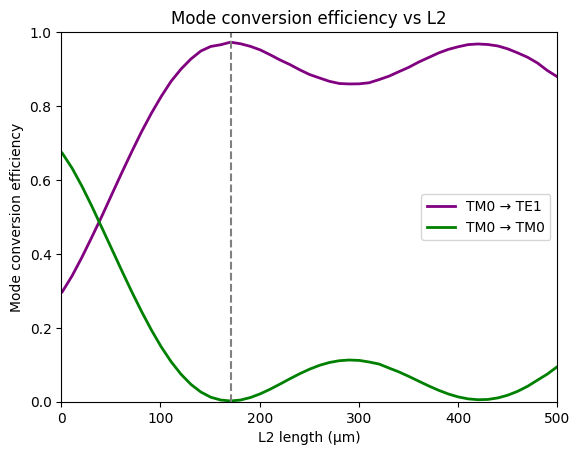

Optimal length: 170.66


In [13]:
plt.plot(l2_scales * l2_sweep, l2_TM0_TE1, c="purple", linewidth=2, label="TM0 → TE1")
plt.plot(l2_scales * l2_sweep, l2_TM0_TM0, c="green", linewidth=2, label="TM0 → TM0")
plt.xlim(0, 500)
plt.ylim(0, 1)
plt.xlabel("L2 length (μm)")
plt.ylabel("Mode conversion efficiency")
plt.title("Mode conversion efficiency vs L2")
plt.axvline(x=l2, color="gray", ls="--")
plt.legend()
plt.show()
print(f"Optimal length: {l2}")

These results are fairly different from what is inside the paper. To verify our results, we will run FDTD validations of $L_2=170.66$ and $L_2=250$:

## FDTD Validation of EME L2 Sweep

The FDTD method, while much slower and more expensive than the EME method, is more robust. It is always a good idea to double-check our simulation results with multiple methods. Thus we will define a function that creates an FDTD simulation with a given $L_2$ value. This way we can easily create multiple FDTD simulations with multiple $L_2$ values.

In [14]:
def make_l2_FDTD_sim(l2_sweep):

    # create taper structure
    l2_test_pts = [
        (-10, -w0 / 2),
        (0, -w0 / 2),
        (l1, -w1 / 2),
        (l1 + l2_sweep, -w2 / 2),
        (l1 + l2_sweep + l3, -w3 / 2),
        (l1 + l2_sweep + l3 + 10, -w3 / 2),
        (l1 + l2_sweep + l3 + 10, w3 / 2),
        (l1 + l2_sweep + l3, w3 / 2),
        (l1 + l2_sweep, w2 / 2),
        (l1, w1 / 2),
        (0, w0 / 2),
        (-10, w0 / 2),
    ]
    l2_test_structures = make_ridge_waveguide(l2_test_pts)

    # add mode monitor
    l2_mode_monitor = td.ModeMonitor(
        name="l2 mode",
        size=(0, td.inf, td.inf),
        center=(l1 + l2_sweep + l3 * 0.95, 0, 0),
        freqs=[freq0],
        mode_spec=td.ModeSpec(num_modes=2, target_neff=n_o),
    )

    # specify FDTD grid
    auto_x = td.AutoGrid(min_steps_per_wvl=10)
    auto_yz = td.AutoGrid(min_steps_per_wvl=30)

    # create simulation with these specs
    l2_sweep_sim = td.Simulation(
        center=((l1 + l2_sweep + l3) / 2, 0, 0),
        size=(l1 + l2_sweep + l3, w3 + 2 * w0, 5 * film_thickness),
        sources=[],
        structures=l2_test_structures,
        grid_spec=td.GridSpec(grid_x=auto_x, grid_y=auto_yz, grid_z=auto_yz, wavelength=wvl0),
        medium=SiO2,
        monitors=[l2_mode_monitor],
        symmetry=(0, 1, 0),
        run_time=5e-12,
    )

    """
    To inject the right mode into the FDTD simulation, we will need to solve for this correct
    mode in FDTD. We will convert this to a source and add it to the simulation.
    """
    fdtd_mode_solver = ModeSolver(
        simulation=l2_sweep_sim,
        plane=td.Box(center=(1, 0, 0), size=(0, td.inf, td.inf)),
        mode_spec=td.ModeSpec(num_modes=3, target_neff=n_o),
        freqs=[freq0],
    )
    fdtd_source = fdtd_mode_solver.to_source(
        mode_index=0, direction="+", source_time=td.GaussianPulse(freq0=freq0, fwidth=freq0 / 10)
    )
    return l2_sweep_sim.updated_copy(sources=[fdtd_source])

In [15]:
# create FDTD simulations where L2 = l2, 250 μm
l2_FDTD_opt_sim = make_l2_FDTD_sim(l2)
l2_FDTD_250_sim = make_l2_FDTD_sim(250)

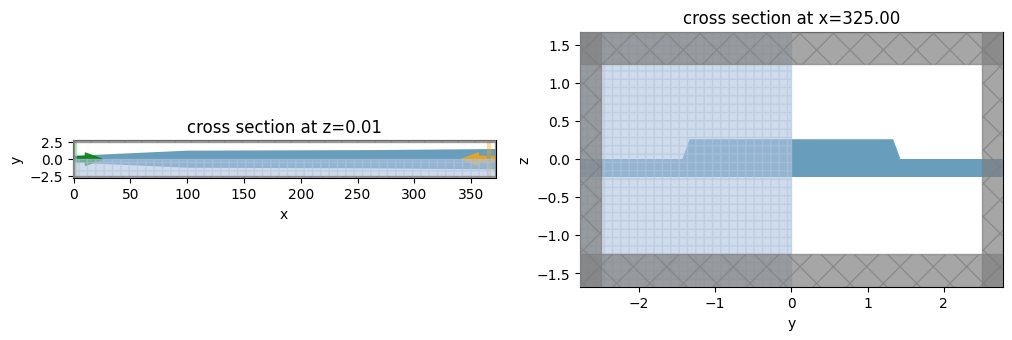

In [16]:
# validate our FDTD-creating function
_, ax = plt.subplots(1, 2, figsize=(12, 4))
l2_FDTD_opt_sim.plot(z=0.005, ax=ax[0])
l2_FDTD_opt_sim.plot(x=l1 + 125 + l3, ax=ax[1])
ax[0].set_aspect(6)
plt.show()

In [17]:
l2_FDTD_opt_data = web.run(simulation=l2_FDTD_opt_sim, task_name="L2 FDTD opt")
l2_FDTD_250_data = web.run(simulation=l2_FDTD_250_sim, task_name="L2 FDTD 250")

08:06:19 PDT Created task 'L2 FDTD opt' with task_id                            
             'fdve-638f0fa8-94dd-4235-9265-114965c23151' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=861023;https://tidy3d.simulation.cloud/workbench?taskId=fdve-638f0fa8-94dd-4235-9265-114965c23151\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=889591;https://tidy3d.simulation.cloud/workbench?taskId=fdve-638f0fa8-94dd-4235-9265-114965c23151\taskId]8;;\]8;id=861023;https://tidy3d.simulation.cloud/workbench?taskId=fdve-638f0fa8-94dd-4235-9265-114965c23151\=]8;;\]8;id=551364;https://tidy3d.simulation.cloud/workbench?taskId=fdve-638f0fa8-94dd-4235-9265-114965c23151\fdve]8;;\]8;id=861023;https://tidy3d.simulation.cloud/workbench?taskId=fdve-638f0fa8-94dd-4235-9265-114965c23151\-638f0fa8-94d]8;;\
             ]8;id=861023;https://tidy3d.simulation.cloud/workbench?taskId=fdve-638f0fa8-94dd-4235-9265-114965c23151\d-4235-9265-114965c23151']8;;\.

Output()

08:06:20 PDT status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

08:06:25 PDT status = preprocess

08:06:27 PDT Maximum FlexCredit cost: 2.081. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

08:08:10 PDT early shutoff detected at 68%, exiting.

             status = success

             View simulation result at                                          
             ]8;id=484130;https://tidy3d.simulation.cloud/workbench?taskId=fdve-638f0fa8-94dd-4235-9265-114965c23151\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=212671;https://tidy3d.simulation.cloud/workbench?taskId=fdve-638f0fa8-94dd-4235-9265-114965c23151\taskId]8;;\]8;id=484130;https://tidy3d.simulation.cloud/workbench?taskId=fdve-638f0fa8-94dd-4235-9265-114965c23151\=]8;;\]8;id=519234;https://tidy3d.simulation.cloud/workbench?taskId=fdve-638f0fa8-94dd-4235-9265-114965c23151\fdve]8;;\]8;id=484130;https://tidy3d.simulation.cloud/workbench?taskId=fdve-638f0fa8-94dd-4235-9265-114965c23151\-638f0fa8-94d]8;;\
             ]8;id=484130;https://tidy3d.simulation.cloud/workbench?taskId=fdve-638f0fa8-94dd-4235-9265-114965c23151\d-4235-9265-114965c23151']8;;\.

Output()

             loading simulation from simulation_data.hdf5

08:08:11 PDT Created task 'L2 FDTD 250' with task_id                            
             'fdve-3cde6cdc-7633-453e-8f4d-bc296d03bef1' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=967553;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3cde6cdc-7633-453e-8f4d-bc296d03bef1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=789812;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3cde6cdc-7633-453e-8f4d-bc296d03bef1\taskId]8;;\]8;id=967553;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3cde6cdc-7633-453e-8f4d-bc296d03bef1\=]8;;\]8;id=351573;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3cde6cdc-7633-453e-8f4d-bc296d03bef1\fdve]8;;\]8;id=967553;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3cde6cdc-7633-453e-8f4d-bc296d03bef1\-3cde6cdc-763]8;;\
             ]8;id=967553;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3cde6cdc-7633-453e-8f4d-bc296d03bef1\3-453e-8f4d-bc296d03bef1']8;;\.

Output()

08:08:12 PDT status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

08:08:17 PDT status = preprocess

08:08:19 PDT Maximum FlexCredit cost: 2.511. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

08:08:20 PDT running solver

Output()

08:10:38 PDT early shutoff detected at 80%, exiting.

             status = success

             View simulation result at                                          
             ]8;id=929475;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3cde6cdc-7633-453e-8f4d-bc296d03bef1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=187992;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3cde6cdc-7633-453e-8f4d-bc296d03bef1\taskId]8;;\]8;id=929475;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3cde6cdc-7633-453e-8f4d-bc296d03bef1\=]8;;\]8;id=721824;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3cde6cdc-7633-453e-8f4d-bc296d03bef1\fdve]8;;\]8;id=929475;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3cde6cdc-7633-453e-8f4d-bc296d03bef1\-3cde6cdc-763]8;;\
             ]8;id=929475;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3cde6cdc-7633-453e-8f4d-bc296d03bef1\3-453e-8f4d-bc296d03bef1']8;;\.

Output()

08:10:39 PDT loading simulation from simulation_data.hdf5

Now that we have run our equivalent FDTD simulations, we will check these values against our EME values.

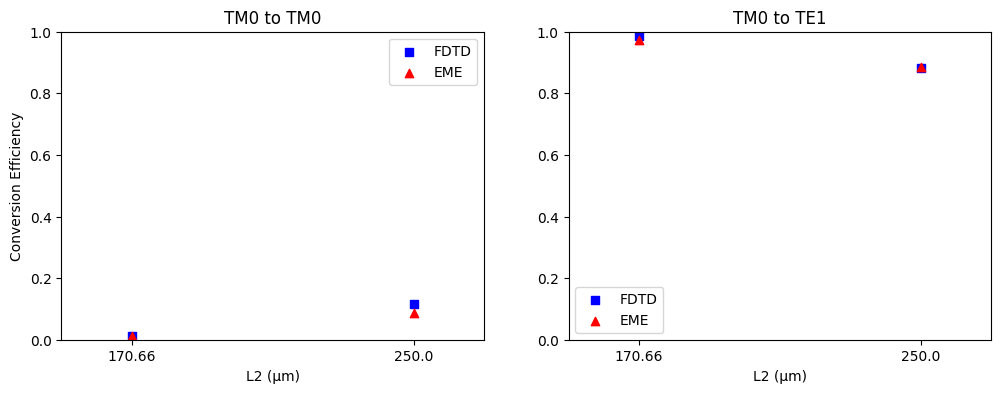

In [18]:
TM0_TM0_opt_FDTD = (
    l2_FDTD_opt_data["l2 mode"].amps.sel(direction="+", mode_index=1).abs.data[0] ** 2
)
TM0_TE1_opt_FDTD = (
    l2_FDTD_opt_data["l2 mode"].amps.sel(direction="+", mode_index=0).abs.data[0] ** 2
)

TM0_TM0_opt_EME = l2_TM0_TM0[arg_min]
TM0_TE1_opt_EME = l2_TM0_TE1[arg_min]

TM0_TM0_250_FDTD = (
    l2_FDTD_250_data["l2 mode"].amps.sel(direction="+", mode_index=1).abs.data[0] ** 2
)
TM0_TE1_250_FDTD = (
    l2_FDTD_250_data["l2 mode"].amps.sel(direction="+", mode_index=0).abs.data[0] ** 2
)
TM0_TM0_250_EME = l2_TM0_TM0[25]
TM0_TE1_250_EME = l2_TM0_TE1[25]

lengths_l2 = np.array([l2, 250])
TM0_FDTD = np.array([TM0_TM0_opt_FDTD, TM0_TM0_250_FDTD])
TM0_EME = np.array([TM0_TM0_opt_FDTD, TM0_TM0_250_EME])
TE1_FDTD = np.array([TM0_TE1_opt_FDTD, TM0_TE1_250_FDTD])
TE1_EME = np.array([TM0_TE1_opt_EME, TM0_TE1_250_EME])

_, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].scatter(lengths_l2, TM0_FDTD, marker="s", c="blue", label="FDTD")
ax[0].scatter(lengths_l2, TM0_EME, marker="^", c="red", label="EME")
ax[0].legend()
ax[0].set_ylim(0, 1)
ax[0].set_xticks(lengths_l2, lengths_l2)
ax[0].margins(0.25)
ax[0].set_xlabel("L2 (μm)")
ax[0].set_ylabel("Conversion Efficiency")
ax[0].set_title("TM0 to TM0")

ax[1].scatter(lengths_l2, TE1_FDTD, marker="s", c="blue", label="FDTD")
ax[1].scatter(lengths_l2, TE1_EME, marker="^", c="red", label="EME")
ax[1].legend()
ax[1].set_ylim(0, 1)
ax[1].set_xticks(lengths_l2, lengths_l2)
ax[1].margins(0.25)
ax[1].set_xlabel("L2 (μm)")
ax[1].set_title("TM0 to TE1")

plt.show()

These results coincide nicely, verifying the accuracy of our EME sweep. Now let's check the field profile from our EME simulation where $L_2$ = 170.66 μm, as this is where maximum efficiency occurs. We will do this by adding a field monitor to this simulation.

In [19]:
# create taper structure
l2_ideal_pts = [
    (-10, -w0 / 2),
    (0, -w0 / 2),
    (l1, -w1 / 2),
    (l1 + l2, -w2 / 2),
    (l1 + l2 + l3, -w3 / 2),
    (l1 + l2 + l3 + 10, -w3 / 2),
    (l1 + l2 + l3 + 10, w3 / 2),
    (l1 + l2 + l3, w3 / 2),
    (l1 + l2, w2 / 2),
    (l1, w1 / 2),
    (0, w0 / 2),
    (-10, w0 / 2),
]
l2_ideal_structures = make_ridge_waveguide(l2_test_pts)

# create field monitor
l2_field_monitor = td.EMEFieldMonitor(
    name="l2 field",
    size=(td.inf, td.inf, 0),
    center=(l1 + l2 + l3 * 0.95, 0, 0),
    freqs=[freq0],
    fields=["Ex", "Ey", "Ez"],
    num_modes=4,
)

# add field monitor to EME simulation
optimal_l2_sim = l2_sweep_sim.updated_copy(
    structures=l2_ideal_structures, monitors=[l2_field_monitor], symmetry=(0, 0, 0), sweep_spec=None
)

In [20]:
ideal_l2_data = web.run(simulation=optimal_l2_sim, task_name="Ideal L2 field validation")

             Created task 'Ideal L2 field validation' with task_id              
             'eme-6debabac-218e-46ca-89dc-440924c71447' and task_type 'EME'.

             Tidy3D's EME solver is currently in the beta stage. Cost of EME    
             simulations is subject to change in the future.

Output()

08:10:40 PDT status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

08:10:53 PDT Maximum FlexCredit cost: 0.420. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

08:13:05 PDT status = success

Output()

08:13:39 PDT loading simulation from simulation_data.hdf5

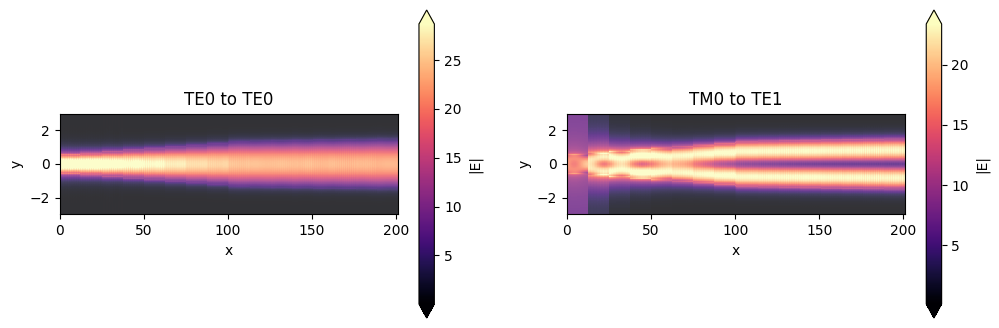

In [21]:
_, ax = plt.subplots(1, 2, figsize=(12, 4))

ideal_l2_data.plot_field("l2 field", "E", "abs", f=freq0, eme_port_index=0, mode_index=0, ax=ax[0])
ideal_l2_data.plot_field("l2 field", "E", "abs", f=freq0, eme_port_index=1, mode_index=1, ax=ax[1])
ax[0].set_aspect(10)
ax[1].set_aspect(10)
ax[0].set_title("TE0 to TE0")
ax[1].set_title("TM0 to TE1")
plt.show()

## Design of Asymmetric Y-Junction

We now move forward with the design of the Y-junction. The purpose of this junction is to separate TE0 and TE1 modes - in the wider arm of the junction, a TE0 mode will stay a
TE0 mode since the effective refractive indices of the modes will be closest, and, in the thinner arm, a TE1 mode will evolve to a TE0 mode for the same reason. The widths we will choose in order to enable this will be 1.7 μm and 1.3 μm, respectively. We will choose the final distance between the arms to be 1 μm.

This mode conversion will only happen adiabatically, so the angle splitting the two arms must be very small. The central question of our design, therefore, is how long the Y-junction will be. To find the optimal length (which we'll denote as $L_4$), we will use Tidy3D's EME sweep feature to do screen various $L_4$ lengths. Tidy3D's EME sweep feature is a fast and inexpensive way to run sweeps where the entire simulation is scaled, which is ideal for testing this geometry.

We will measure the TE0 and TM0 conversion efficiencies in both arms. The upper, wider arm will be labeled 'port 1' and the lower, thinner arm will be labeled 'port 2.'

In [22]:
w4 = 1.7  # width of upper arm
w5 = 1.3  # width of lower arm
split = 1  # ending distance between two arms

# the starting length for the Y-junction. This will change as we change the scale
l4_sweep = 100

# create Y-junction geometry and structure
l4_test_pts = [
    (-l3, -w2 / 2),  #
    (0, -w3 / 2),
    (l4_sweep * 2, 2 * (-split / 2) - w5),  # extend beyond boundary
    (l4_sweep * 2, 2 * (-split / 2)),  # extend beyond boundary
    (0, -w3 / 2 + w5),
    (l4_sweep * 2, 2 * (split / 2)),  # extend beyond boundary
    (l4_sweep * 2, 2 * (split / 2) + w4),  # extend beyond boundary
    (0, w3 / 2),
    (-l3, w2 / 2),  #
]
l4_test_structures = make_ridge_waveguide(l4_test_pts)

num_modes = 5
l4_port1 = td.ModeSolverMonitor(
    name="l4 port 1",
    size=(0, w4 + 1.5 * split, td.inf),
    center=(l4_sweep - 0.1, (-w3 / 2 + w5) + split / 2 + w4 / 2, 0),
    freqs=[freq0],
    mode_spec=td.ModeSpec(
        num_modes=num_modes,
        target_neff=n_o,
        angle_theta=np.arctan((split / 2 - (-w3 / 2 + w5)) / l4_sweep),
    ),
)

l4_port2 = td.ModeSolverMonitor(
    name="l4 port 2",
    size=(0, w5 + 1.5 * split, td.inf),
    center=(l4_sweep - 0.1, -split / 2 - w5 / 2, 0),
    freqs=[freq0],
    mode_spec=td.ModeSpec(
        num_modes=num_modes,
        target_neff=n_o,
        angle_theta=np.arctan((-split / 2 - w5 / 2 + w3 / 4) / l4_sweep),
    ),
)

# again owing to the adiabatic nature of this problem, we need only use a unifrom grid throughout the simulation
l3_grid_spec = td.EMEUniformGrid(num_cells=16, mode_spec=td.EMEModeSpec(num_modes=num_modes))
l4_grid_spec = td.EMEUniformGrid(num_cells=41, mode_spec=td.EMEModeSpec(num_modes=num_modes))
l4_total_grid = td.EMECompositeGrid(subgrids=[l3_grid_spec, l4_grid_spec], subgrid_boundaries=[0])

auto_x = td.AutoGrid(min_steps_per_wvl=31)
auto_yz = td.AutoGrid(min_steps_per_wvl=41)
refine_box = td.MeshOverrideStructure(
    geometry=td.Box(center=(0, -w3 / 2 + w5, 0), size=(l4_sweep + l3, split / 2, 2.5 * etch_depth)),
    dl=[0.1, 0.01, 0.01],
)

l4_scales = np.linspace(1 / l4_sweep, 200 / l4_sweep, 61)
l4_scale_factors = np.ones((len(l4_scales), l3_grid_spec.num_cells + l4_grid_spec.num_cells))
l4_scale_factors[:, l3_grid_spec.num_cells : l3_grid_spec.num_cells + l4_grid_spec.num_cells] = (
    l4_scales[:, None]
)

l4_EME = td.EMESimulation(
    center=((l4_sweep - l3) / 2, 0, 0),
    size=(l4_sweep + l3, 3 * split + w4 + w5, 5 * film_thickness),
    structures=l4_test_structures,
    grid_spec=td.GridSpec(grid_x=auto_x, grid_y=auto_yz, grid_z=auto_yz, wavelength=wvl0),
    medium=SiO2,
    monitors=[l4_port1, l4_port2],
    eme_grid_spec=l4_total_grid,
    freqs=[freq0],
    sweep_spec=td.EMELengthSweep(scale_factors=list(l4_scale_factors)),
    axis=0,
)

08:13:41 PDT ERROR: Expected 1 dimensions for ArrayLike, got 2.                 

             WARNING: Structure at 'structures[1]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

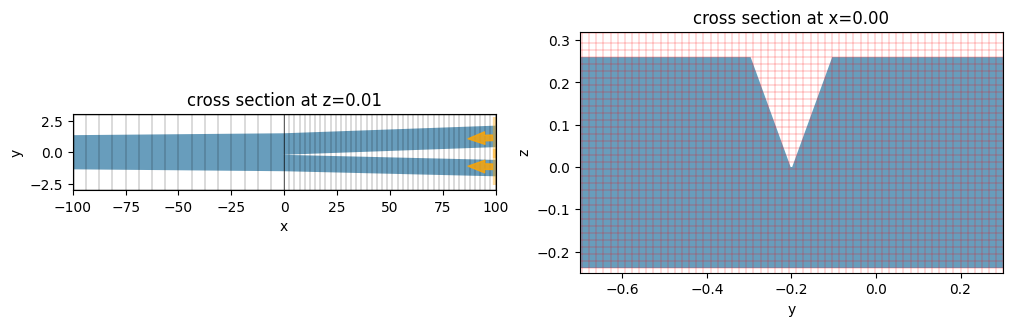

In [23]:
x_plot = 0

_, ax = plt.subplots(1, 2, figsize=(12, 4))
l4_EME.plot(z=0.005, ax=ax[0])

l4_EME.plot(x=x_plot, ax=ax[1])
l4_EME.plot_grid(x=x_plot, ax=ax[1], lw=0.4, colors="r")
ax[0].set_aspect(6)
ax[1].set_xlim(-0.7, 0.3)
ax[1].set_ylim(-0.25, 0.32)
plt.show()

In [24]:
l4_EME_data = web.run(l4_EME, task_name="L4 EME sweep")

08:13:42 PDT Created task 'L4 EME sweep' with task_id                           
             'eme-2b0406e9-f4c5-4e35-8e22-7cbc0e45a25e' and task_type 'EME'.

             Tidy3D's EME solver is currently in the beta stage. Cost of EME    
             simulations is subject to change in the future.

Output()

08:13:44 PDT status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

08:14:26 PDT Maximum FlexCredit cost: 0.708. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

08:14:27 PDT running solver

08:21:36 PDT status = success

Output()

08:21:41 PDT loading simulation from simulation_data.hdf5

             WARNING: Structure at 'structures[1]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             ERROR: Expected 1 dimensions for ArrayLike, got 2.                 

             WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

We want to examine the scattering matrix in the bases of modes in each junction arm. The `EMESimulationData.smatrix_in_basis` data is thus what we want to examine.

In [25]:
web.download("eme-9375b55c-4084-4102-a253-85e8f8deaf15")

Output()

In [26]:
TE0_TE0_port1 = (
    l4_EME_data.smatrix_in_basis(modes2=l4_EME_data["l4 port 1"])
    .S21.sel(f=freq0, mode_index_in=0, mode_index_out=0)
    .abs.data
    ** 2
)
TE0_TE0_port2 = (
    l4_EME_data.smatrix_in_basis(modes2=l4_EME_data["l4 port 2"])
    .S21.sel(f=freq0, mode_index_in=0, mode_index_out=0)
    .abs.data
    ** 2
)
TE0_TM0_port1 = (
    l4_EME_data.smatrix_in_basis(modes2=l4_EME_data["l4 port 1"])
    .S21.sel(f=freq0, mode_index_in=0, mode_index_out=1)
    .abs.data
    ** 2
)
TE0_TM0_port2 = (
    l4_EME_data.smatrix_in_basis(modes2=l4_EME_data["l4 port 2"])
    .S21.sel(f=freq0, mode_index_in=0, mode_index_out=1)
    .abs.data
    ** 2
)

TE1_TE0_port1 = (
    l4_EME_data.smatrix_in_basis(modes2=l4_EME_data["l4 port 1"])
    .S21.sel(f=freq0, mode_index_in=1, mode_index_out=0)
    .abs.data
    ** 2
)
TE1_TE0_port2 = (
    l4_EME_data.smatrix_in_basis(modes2=l4_EME_data["l4 port 2"])
    .S21.sel(f=freq0, mode_index_in=1, mode_index_out=0)
    .abs.data
    ** 2
)
TE1_TM0_port1 = (
    l4_EME_data.smatrix_in_basis(modes2=l4_EME_data["l4 port 1"])
    .S21.sel(f=freq0, mode_index_in=1, mode_index_out=1)
    .abs.data
    ** 2
)
TE1_TM0_port2 = (
    l4_EME_data.smatrix_in_basis(modes2=l4_EME_data["l4 port 2"])
    .S21.sel(f=freq0, mode_index_in=1, mode_index_out=1)
    .abs.data
    ** 2
)

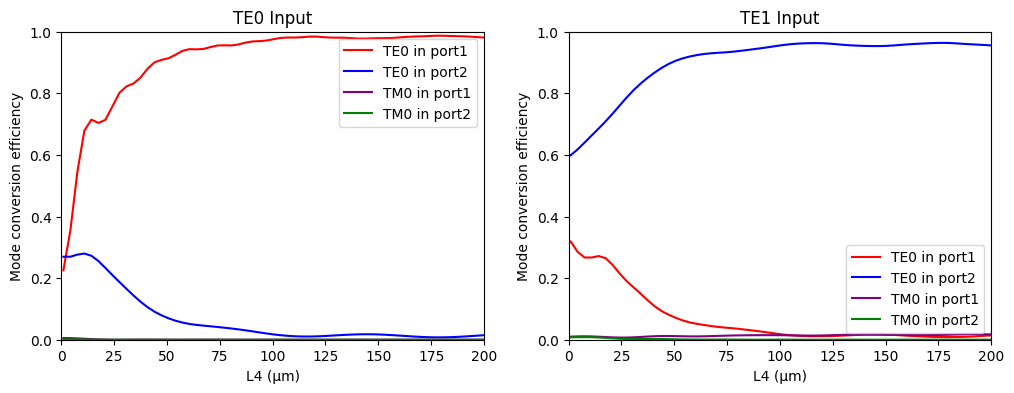

Optimal L4: 117.08333333333331


In [27]:
_, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(l4_scales * l4_sweep, TE0_TE0_port1, c="red", label="TE0 in port1")
ax[0].plot(l4_scales * l4_sweep, TE0_TE0_port2, c="blue", label="TE0 in port2")
ax[0].plot(l4_scales * l4_sweep, TE0_TM0_port1, c="purple", label="TM0 in port1")
ax[0].plot(l4_scales * l4_sweep, TE0_TM0_port2, c="green", label="TM0 in port2")
ax[0].set_xlim((0, 200))
ax[0].set_ylim((0, 1))
ax[0].legend()
ax[0].set_xlabel("L4 (μm)")
ax[0].set_ylabel("Mode conversion efficiency")
ax[0].set_title("TE0 Input")

ax[1].plot(l4_scales * l4_sweep, TE1_TE0_port1, c="red", label="TE0 in port1")
ax[1].plot(l4_scales * l4_sweep, TE1_TE0_port2, c="blue", label="TE0 in port2")
ax[1].plot(l4_scales * l4_sweep, TE1_TM0_port1, c="purple", label="TM0 in port1")
ax[1].plot(l4_scales * l4_sweep, TE1_TM0_port2, c="green", label="TM0 in port2")
ax[1].set_xlim((0, 200))
ax[1].set_ylim((0, 1))
ax[1].legend()
ax[1].set_xlabel("L4 (μm)")
ax[1].set_ylabel("Mode conversion efficiency")
ax[1].set_title("TE1 Input")

plt.show()

l4 = l4_sweep * l4_scales[np.argmin(TE0_TE0_port2[:40])]
print(f"Optimal L4: {l4}")

## Full FDTD Device Simulation

Now we will combine our optimized taper and Y-junction to create a full polarizer/rotator in FDTD and examine the results:

In [28]:
# Add buffer to extend structure into the boundary to avoid sidewall angle trouble
buffer = 2

# Create full polarization rotator/splitter structure in LNOI
full_pts = [
    (-buffer, -w0 / 2),
    (0, -w0 / 2),
    (l1, -w1 / 2),
    (l1 + l2, -w2 / 2),
    (l1 + l2 + l3, -w3 / 2),
    (l1 + l2 + l3 + 2 * l4, 2 * (-split / 2) - w5),
    (l1 + l2 + l3 + 2 * l4, 2 * (-split / 2)),
    (l1 + l2 + l3, -w3 / 2 + w5),
    (l1 + l2 + l3 + 2 * l4, 2 * (split / 2)),
    (l1 + l2 + l3 + 2 * l4, 2 * (split / 2) + w4),
    (l1 + l2 + l3, w3 / 2),
    (l1 + l2, w2 / 2),
    (l1, w1 / 2),
    (0, w0 / 2),
    (-buffer, w0 / 2),
]
full_structure = make_ridge_waveguide(full_pts)

# Create mode monitors
full_port1 = td.ModeMonitor(
    name="Full Port 1",
    size=(0, w4 + 1.5 * split, td.inf),
    center=(l1 + l2 + l3 + l4 - 1, (-w3 / 2 + w5) + split / 2 + w4 / 2, 0),
    freqs=freqs[::2],
    mode_spec=td.ModeSpec(
        num_modes=num_modes,
        target_neff=n_o,
        angle_theta=np.arctan((split / 2 - (-w3 / 2 + w5)) / l4),
    ),
)
full_port2 = td.ModeMonitor(
    name="Full Port 2",
    size=(0, w5 + 1.5 * split, td.inf),
    center=(l1 + l2 + l3 + l4 - 1, -split / 2 - w5 / 2, 0),
    freqs=freqs[::2],
    mode_spec=td.ModeSpec(
        num_modes=num_modes,
        target_neff=n_o,
        angle_theta=np.arctan((-split / 2 - w5 / 2 + w3 / 4) / l4),
    ),
)
full_field = td.FieldMonitor(name="Full Field", size=(td.inf, td.inf, 0), freqs=[freq0])

auto_x = td.AutoGrid(min_steps_per_wvl=11)

# Create simulation
full_sim = td.Simulation(
    center=((l1 + l2 + l3 + l4) / 2, 0, 0),
    size=(l1 + l2 + l3 + l4, 3 * split + w4 + w5, 5 * film_thickness),
    structures=full_structure,
    grid_spec=td.GridSpec(grid_x=auto_x, grid_y=auto_yz, grid_z=auto_yz, wavelength=wvl0),
    medium=SiO2,
    sources=[],
    monitors=[full_port1, full_port2, full_field],
    run_time=5e-12,
)

"""
Solve for modes to be able to launch them as a source. We will create two simulations, one with the TE0 mode as a source, and one
with a TM0 mode as a source.
"""
full_mode_solver = ModeSolver(
    simulation=full_sim,
    plane=td.Box(center=(1, 0, 0), size=(0, td.inf, td.inf)),
    mode_spec=td.ModeSpec(num_modes=3, target_neff=n_o),
    freqs=[freq0],
)
full_source_TE0 = full_mode_solver.to_source(
    mode_index=0, direction="+", source_time=td.GaussianPulse(freq0=freq0, fwidth=freq0 / 10)
)
full_source_TM0 = full_source_TE0.updated_copy(mode_index=1)

full_sim_TE0 = full_sim.updated_copy(sources=[full_source_TE0])
full_sim_TM0 = full_sim.updated_copy(sources=[full_source_TM0])

08:21:56 PDT WARNING: Structure at structures[1] was detected as being less than
             half of a central wavelength from a PML on side y-min. To avoid    
             inaccurate results or divergence, please increase gap between any  
             structures and PML or fully extend structure through the pml.      

             WARNING: Suppressed 1 WARNING message.                             

             WARNING: Structure at structures[1] was detected as being less than
             half of a central wavelength from a PML on side y-min. To avoid    
             inaccurate results or divergence, please increase gap between any  
             structures and PML or fully extend structure through the pml.      

             WARNING: Suppressed 1 WARNING message.                             

Before we run we'll check that we've constructed the simulation correctly.

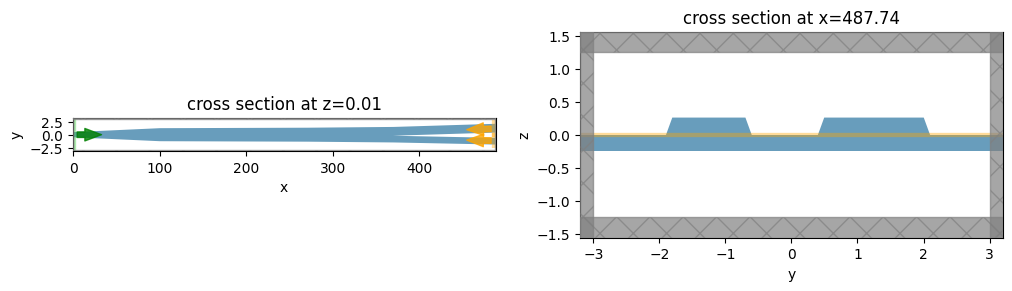

In [29]:
_, ax = plt.subplots(1, 2, figsize=(12, 4))
full_sim_TE0.plot(z=0.005, ax=ax[0])
full_sim_TE0.plot(x=l1 + l2 + l3 + l4, ax=ax[1])
ax[0].set_aspect(6)
plt.show()

In [30]:
full_TE0_data = web.run(simulation=full_sim_TE0, task_name="Full FDTD pol/rot TE0")
full_TM0_data = web.run(simulation=full_sim_TM0, task_name="Full FDTD pol/rot TM0")

             Created task 'Full FDTD pol/rot TE0' with task_id                  
             'fdve-69ad3792-88f9-4b09-8932-b1b7c38ebf3e' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=444688;https://tidy3d.simulation.cloud/workbench?taskId=fdve-69ad3792-88f9-4b09-8932-b1b7c38ebf3e\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=434798;https://tidy3d.simulation.cloud/workbench?taskId=fdve-69ad3792-88f9-4b09-8932-b1b7c38ebf3e\taskId]8;;\]8;id=444688;https://tidy3d.simulation.cloud/workbench?taskId=fdve-69ad3792-88f9-4b09-8932-b1b7c38ebf3e\=]8;;\]8;id=223687;https://tidy3d.simulation.cloud/workbench?taskId=fdve-69ad3792-88f9-4b09-8932-b1b7c38ebf3e\fdve]8;;\]8;id=444688;https://tidy3d.simulation.cloud/workbench?taskId=fdve-69ad3792-88f9-4b09-8932-b1b7c38ebf3e\-69ad3792-88f]8;;\
             ]8;id=444688;https://tidy3d.simulation.cloud/workbench?taskId=fdve-69ad3792-88f9-4b09-8932-b1b7c38ebf3e\9-4b09-8932-b1b7c38ebf3e']8;;\.

Output()

08:21:58 PDT status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

08:22:03 PDT status = preprocess

08:22:20 PDT Maximum FlexCredit cost: 15.003. Use 'web.real_cost(task_id)' to   
             get the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

08:25:58 PDT early shutoff detected at 84%, exiting.

08:25:59 PDT status = postprocess

Output()

08:26:04 PDT status = success

08:26:05 PDT View simulation result at                                          
             ]8;id=596133;https://tidy3d.simulation.cloud/workbench?taskId=fdve-69ad3792-88f9-4b09-8932-b1b7c38ebf3e\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=502031;https://tidy3d.simulation.cloud/workbench?taskId=fdve-69ad3792-88f9-4b09-8932-b1b7c38ebf3e\taskId]8;;\]8;id=596133;https://tidy3d.simulation.cloud/workbench?taskId=fdve-69ad3792-88f9-4b09-8932-b1b7c38ebf3e\=]8;;\]8;id=797193;https://tidy3d.simulation.cloud/workbench?taskId=fdve-69ad3792-88f9-4b09-8932-b1b7c38ebf3e\fdve]8;;\]8;id=596133;https://tidy3d.simulation.cloud/workbench?taskId=fdve-69ad3792-88f9-4b09-8932-b1b7c38ebf3e\-69ad3792-88f]8;;\
             ]8;id=596133;https://tidy3d.simulation.cloud/workbench?taskId=fdve-69ad3792-88f9-4b09-8932-b1b7c38ebf3e\9-4b09-8932-b1b7c38ebf3e']8;;\.

Output()

08:26:21 PDT loading simulation from simulation_data.hdf5

             WARNING: Structure at structures[1] was detected as being less than
             half of a central wavelength from a PML on side y-min. To avoid    
             inaccurate results or divergence, please increase gap between any  
             structures and PML or fully extend structure through the pml.      

             WARNING: Suppressed 1 WARNING message.                             

             WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

             Created task 'Full FDTD pol/rot TM0' with task_id                  
             'fdve-f26a1e1e-f7dd-4562-9ec4-e2df04c3c393' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=727059;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f26a1e1e-f7dd-4562-9ec4-e2df04c3c393\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=34344;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f26a1e1e-f7dd-4562-9ec4-e2df04c3c393\taskId]8;;\]8;id=727059;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f26a1e1e-f7dd-4562-9ec4-e2df04c3c393\=]8;;\]8;id=669264;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f26a1e1e-f7dd-4562-9ec4-e2df04c3c393\fdve]8;;\]8;id=727059;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f26a1e1e-f7dd-4562-9ec4-e2df04c3c393\-f26a1e1e-f7d]8;;\
             ]8;id=727059;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f26a1e1e-f7dd-4562-9ec4-e2df04c3c393\d-4562-9ec4-e2df04c3c393']8;;\.

Output()

08:26:23 PDT status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

08:26:28 PDT status = preprocess

08:26:43 PDT Maximum FlexCredit cost: 15.003. Use 'web.real_cost(task_id)' to   
             get the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

08:30:23 PDT early shutoff detected at 84%, exiting.

             status = postprocess

Output()

08:30:28 PDT status = success

08:30:29 PDT View simulation result at                                          
             ]8;id=16767;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f26a1e1e-f7dd-4562-9ec4-e2df04c3c393\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=585609;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f26a1e1e-f7dd-4562-9ec4-e2df04c3c393\taskId]8;;\]8;id=16767;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f26a1e1e-f7dd-4562-9ec4-e2df04c3c393\=]8;;\]8;id=351396;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f26a1e1e-f7dd-4562-9ec4-e2df04c3c393\fdve]8;;\]8;id=16767;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f26a1e1e-f7dd-4562-9ec4-e2df04c3c393\-f26a1e1e-f7d]8;;\
             ]8;id=16767;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f26a1e1e-f7dd-4562-9ec4-e2df04c3c393\d-4562-9ec4-e2df04c3c393']8;;\.

Output()

08:30:45 PDT loading simulation from simulation_data.hdf5

             WARNING: Structure at structures[1] was detected as being less than
             half of a central wavelength from a PML on side y-min. To avoid    
             inaccurate results or divergence, please increase gap between any  
             structures and PML or fully extend structure through the pml.      

             WARNING: Suppressed 1 WARNING message.                             

             WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

## Full Device Results

Plotting our results, we can see that we get high contrast and low insertion loss for both TE0 and TM0 inputs.

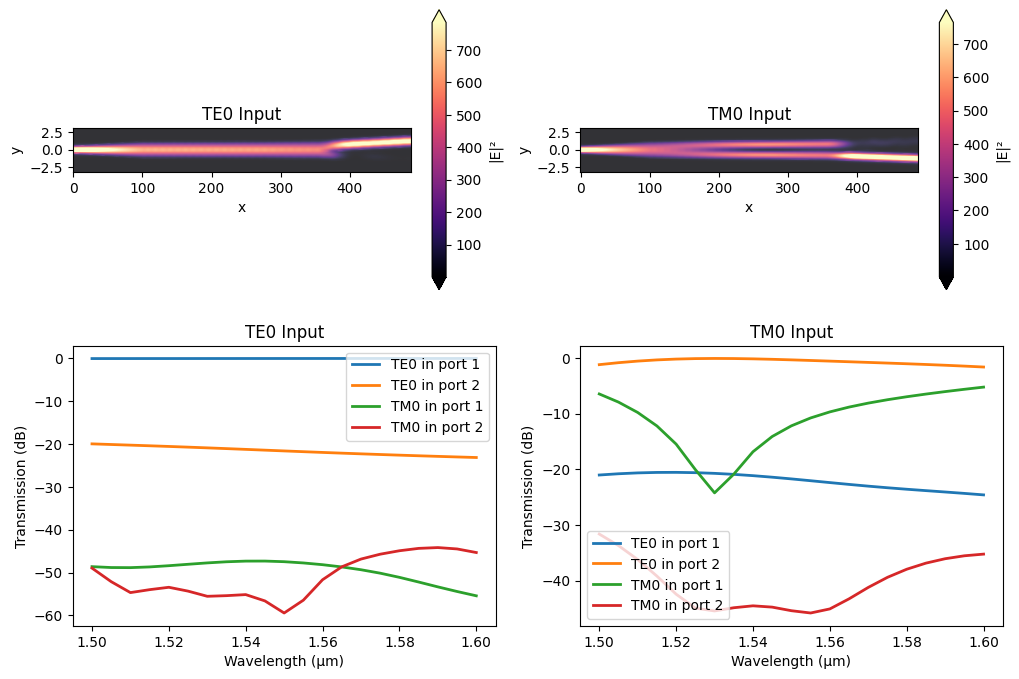

In [31]:
full_TE0_TE0_port1 = np.abs(full_TE0_data["Full Port 1"].amps.sel(mode_index=0, direction="+")) ** 2
full_TE0_TE0_port2 = np.abs(full_TE0_data["Full Port 2"].amps.sel(mode_index=0, direction="+")) ** 2
full_TE0_TM0_port1 = np.abs(full_TE0_data["Full Port 1"].amps.sel(mode_index=1, direction="+")) ** 2
full_TE0_TM0_port2 = np.abs(full_TE0_data["Full Port 2"].amps.sel(mode_index=1, direction="+")) ** 2

full_TM0_TE0_port1 = np.abs(full_TM0_data["Full Port 1"].amps.sel(mode_index=0, direction="+")) ** 2
full_TM0_TE0_port2 = np.abs(full_TM0_data["Full Port 2"].amps.sel(mode_index=0, direction="+")) ** 2
full_TM0_TM0_port1 = np.abs(full_TM0_data["Full Port 1"].amps.sel(mode_index=1, direction="+")) ** 2
full_TM0_TM0_port2 = np.abs(full_TM0_data["Full Port 2"].amps.sel(mode_index=1, direction="+")) ** 2

_, ax = plt.subplots(2, 2, figsize=(12, 8))
full_TE0_data.plot_field("Full Field", "E", "abs^2", ax=ax[0][0])
full_TM0_data.plot_field("Full Field", "E", "abs^2", ax=ax[0][1])
ax[0][0].set_aspect(10)
ax[0][1].set_aspect(10)
ax[0][0].set_title("TE0 Input")
ax[0][1].set_title("TM0 Input")

ax[1][0].plot(wvls[::2], 10 * np.log10(full_TE0_TE0_port1), linewidth=2, label="TE0 in port 1")
ax[1][0].plot(wvls[::2], 10 * np.log10(full_TE0_TE0_port2), linewidth=2, label="TE0 in port 2")
ax[1][0].plot(wvls[::2], 10 * np.log10(full_TE0_TM0_port1), linewidth=2, label="TM0 in port 1")
ax[1][0].plot(wvls[::2], 10 * np.log10(full_TE0_TM0_port2), linewidth=2, label="TM0 in port 2")
ax[1][0].set_title("TE0 Input")
ax[1][0].set_xlabel("Wavelength (μm)")
ax[1][0].set_ylabel("Transmission (dB)")
ax[1][0].legend()

ax[1][1].plot(wvls[::2], 10 * np.log10(full_TM0_TE0_port1), linewidth=2, label="TE0 in port 1")
ax[1][1].plot(wvls[::2], 10 * np.log10(full_TM0_TE0_port2), linewidth=2, label="TE0 in port 2")
ax[1][1].plot(wvls[::2], 10 * np.log10(full_TM0_TM0_port1), linewidth=2, label="TM0 in port 1")
ax[1][1].plot(wvls[::2], 10 * np.log10(full_TM0_TM0_port2), linewidth=2, label="TM0 in port 2")
ax[1][1].set_title("TM0 Input")
ax[1][1].set_xlabel("Wavelength (μm)")
ax[1][1].set_ylabel("Transmission (dB)")
ax[1][1].legend()

plt.show()